In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import subprocess
import pickle
from scipy.stats import describe
from tqdm import tqdm

from astropy.io import fits

from lvmdrp.core import image
from lvmdrp.functions import imageMethod, rssMethod

import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# data root path
LVM_DEV = os.path.expandvars("$LVMHUB")
LVM_ROOT = os.path.join(LVM_DEV, "data.sdss5.org/sas/sdsswork/data/lvm")
LVM_DATA_LAB = os.path.join(LVM_ROOT, "lab")

In [3]:

frames_meta = pd.read_csv(os.path.join(LVM_DATA_LAB, "LVMI Exposure List - Sheet1.csv"))
frames_meta.filename = frames_meta.filename.str.strip()
frames_meta.set_index(["mjd","filename"], inplace=True)
frames_meta = frames_meta.loc[~frames_meta.index.duplicated(keep="first")]
frames_meta = frames_meta.mask(frames_meta==-999)
frames_meta = frames_meta.drop(columns=frames_meta.filter(like="Unnamed"))
frames_meta = frames_meta.dropna(how="all", axis="columns").dropna(how="all", axis="index")

print(f"No. lab frames: {len(frames_meta)}")

No. lab frames: 3498


In [4]:
frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if (pd.to_numeric(os.path.basename(root),errors="ignore"),file) in frames_meta.index])
# frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if file.endswith(".fits") or file.endswith(".fits.gz")])
print(f"frames matched in lab data path: {len(frame_paths)}")

frames matched in lab data path: 3038


In [5]:
frames_header_list_pickle = "_data-lvm/frames_header_list.pk"

new_index = pd.MultiIndex.from_tuples(((pd.to_numeric(os.path.basename(os.path.dirname(file)),errors="ignore"),os.path.basename(file)) for file in frame_paths), names=("mjd", "filename"))
columns = "SPEC IMAGETYP CCDTEMP1 CCDTEMP2 PRESURE LABTEMP LABHUMID M625L4 FFS MI150 TS ARGON XENON HGAR LDLS KRYPTON NEON HGNE".split()

if os.path.isfile(frames_header_list_pickle):
    frames_header_list = pickle.load(open(frames_header_list_pickle, "rb"))
else:
    frames_header_list = []
    for idx, frame_path in tqdm(enumerate(frame_paths), total=len(frame_paths), desc="reading metadata from headers", ascii=True):
        try:
            hdr = fits.getheader(frame_path, ext=0)
        except OSError:
            continue
        
        frames_header_list.append([hdr.get(column, np.nan) for column in columns])
    
    pickle.dump(frames_header_list, open(frames_header_list_pickle, "wb"))

In [6]:
frames_header = pd.DataFrame(index=new_index, columns=columns, data=frames_header_list)
frames_header = frames_header.mask(frames_header==-999).mask(frames_header=="?")

frames_meta_match = frames_meta.loc[new_index]
frames_meta_match = pd.concat((frames_meta_match, frames_header), axis="columns")
frames_meta_match["filepath"] = frame_paths
frames_meta_match

exp_no        date location test_no  \
mjd   filename                                                         
59364 sdR-s-r1-00000318.fits.gz   318.0  30/05/2021      SBS     NaN   
59365 sdR-s-r1-00000325.fits.gz   325.0  31/05/2021      SBS     NaN   
      sdR-s-r1-00000326.fits.gz   326.0  31/05/2021      SBS     NaN   
      sdR-s-r1-00000327.fits.gz   327.0  31/05/2021      SBS     NaN   
      sdR-s-r1-00000328.fits.gz   328.0  31/05/2021      SBS     NaN   
...                                 ...         ...      ...     ...   
59596 sdR-s-z1-00001697.fits.gz  1697.0  17/01/2022      SBS     NaN   
      sdR-s-z1-00001698.fits.gz  1698.0  17/01/2022      SBS     NaN   
      sdR-s-z1-00001699.fits.gz  1699.0  17/01/2022      SBS     NaN   
      sdR-s-z1-00001700.fits.gz  1700.0  17/01/2022      SBS     NaN   
      sdR-s-z1-00001701.fits.gz  1701.0  17/01/2022      SBS     NaN   

                                test_iteration spec channel sources  \
mjd   filename                                                        
59364 sdR-s-r1-00000318.fits.gz            NaN  sp1      r1     NaN   
59365 sdR-s-r1-00000325.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000326.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000327.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000328.fits.gz            NaN  sp1      r1     NaN   
...                                        ...  ...     ...     ...   
59596 sdR-s-z1-00001697.fits.gz            NaN  sp1      z1   Xenon   
      sdR-s-z1-00001698.fits.gz            NaN  sp1      z1   Xenon   
      sdR-s-z1-00001699.fits.gz            NaN  sp1      z1     NaN   
      sdR-s-z1-00001700.fits.gz            NaN  sp1      z1     NaN   
      sdR-s-z1-00001701.fits.gz            NaN  sp1      z1     NaN   

                                lamp_current hartmanns  ... MI150   TS  ARGON  \
mjd   filename                                          ...                     
59364 sdR-s-r1-00000318.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
59365 sdR-s-r1-00000325.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
      sdR-s-r1-00000326.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
      sdR-s-r1-00000327.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
      sdR-s-r1-00000328.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
...                                      ...       ...  ...   ...  ...    ...   
59596 sdR-s-z1-00001697.fits.gz          NaN         L  ...   NaN  NaN    OFF   
      sdR-s-z1-00001698.fits.gz          NaN       NaN  ...   NaN  NaN    OFF   
      sdR-s-z1-00001699.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
      sdR-s-z1-00001700.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
      sdR-s-z1-00001701.fits.gz          NaN       NaN  ...   NaN  OFF    OFF   

                                XENON HGAR LDLS KRYPTON NEON HGNE  \
mjd   filename                                                      
59364 sdR-s-r1-00000318.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN   
59365 sdR-s-r1-00000325.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN   
      sdR-s-r1-00000326.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN   
      sdR-s-r1-00000327.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN   
      sdR-s-r1-00000328.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN   
...                               ...  ...  ...     ...  ...  ...   
59596 sdR-s-z1-00001697.fits.gz    ON  OFF  OFF     OFF  OFF  OFF   
      sdR-s-z1-00001698.fits.gz    ON  OFF  OFF     OFF  OFF  OFF   
      sdR-s-z1-00001699.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN   
      sdR-s-z1-00001700.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN   
      sdR-s-z1-00001701.fits.gz   OFF  OFF  OFF     OFF  OFF  OFF   

                                                                          filepath  
mjd   filename                                                                      
59364 sdR-s-r1-00000318.fits.gz  /disk-a/mejia/Res

<AxesSubplot:>

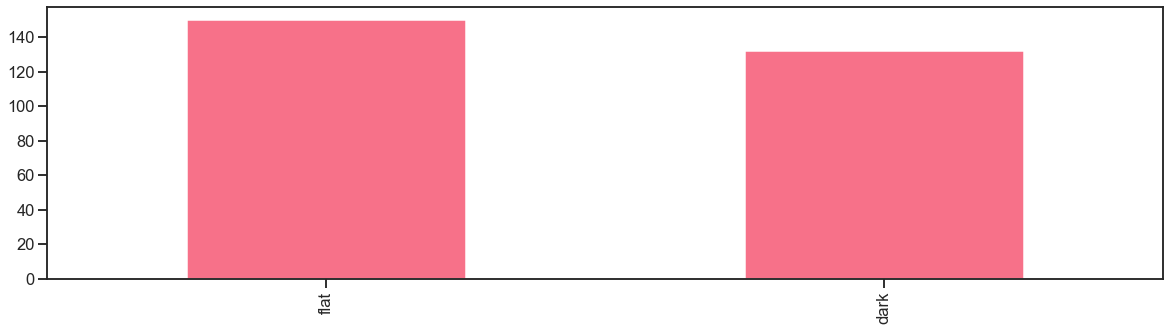

In [7]:
# clean_frames = frames_meta_match.loc[(pd.to_numeric(frames_meta_match.ccd_temp,errors="coerce")<0)&(~frames_meta_match.notes.fillna("").str.contains("bad", case=False))]
# clean_frames = frames_meta_match.loc[frames_meta_match.exp_no.isin(np.arange(1313, 1328+1, dtype=int))]
clean_frames = frames_meta_match.loc[frames_meta_match.exp_no.isin(np.arange(1545, 1638+1, dtype=int))]
clean_frames.IMAGETYP.value_counts().plot(kind="bar", figsize=(20,5))

In [8]:
clean_frames.loc[:, ['SPEC', 'IMAGETYP', 'M625L4', 'FFS', 'MI150', 'TS', 'ARGON', 'XENON', 'HGAR', 'LDLS', 'KRYPTON', 'NEON', 'HGNE']]

SPEC IMAGETYP M625L4  FFS MI150   TS ARGON  \
mjd   filename                                                               
59559 sdR-s-b1-00001545.fits.gz  sp1     flat    NaN  NaN   NaN  NaN    ON   
      sdR-s-b1-00001546.fits.gz  sp1     flat    NaN  NaN   NaN  NaN    ON   
      sdR-s-b1-00001547.fits.gz  sp1     flat    NaN  NaN   NaN  NaN    ON   
      sdR-s-b1-00001548.fits.gz  sp1     flat    NaN  NaN   NaN  NaN    ON   
      sdR-s-b1-00001549.fits.gz  sp1     flat    NaN  NaN   NaN  NaN    ON   
...                              ...      ...    ...  ...   ...  ...   ...   
59570 sdR-s-r1-00001638.fits.gz  sp1     dark    NaN  NaN   NaN  NaN   NaN   
      sdR-s-z1-00001635.fits.gz  sp1     dark    NaN  NaN   NaN  NaN   NaN   
      sdR-s-z1-00001636.fits.gz  sp1     dark    NaN  NaN   NaN  NaN   NaN   
      sdR-s-z1-00001637.fits.gz  sp1     dark    NaN  NaN   NaN  NaN   NaN   
      sdR-s-z1-00001638.fits.gz  sp1     dark    NaN  NaN   NaN  NaN   NaN   

                                XENON HGAR LDLS KRYPTON NEON HGNE  
mjd   filename                                                     
59559 sdR-s-b1-00001545.fits.gz   OFF  OFF  OFF     OFF  OFF  OFF  
      sdR-s-b1-00001546.fits.gz   OFF  OFF  OFF     OFF  OFF  OFF  
      sdR-s-b1-00001547.fits.gz   OFF  OFF  OFF     OFF  OFF  OFF  
      sdR-s-b1-00001548.fits.gz   OFF  OFF  OFF     OFF  OFF  OFF  
      sdR-s-b1-00001549.fits.gz   OFF  OFF  OFF     OFF  OFF  OFF  
...                               ...  ...  ...     ...  ...  ...  
59570 sdR-s-r1-00001638.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN  
      sdR-s-z1-00001635.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN  
      sdR-s-z1-00001636.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN  
      sdR-s-z1-00001637.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN  
      sdR-s-z1-00001638.fits.gz   NaN  NaN  NaN     NaN  NaN  NaN  

[282 rows x 13 columns]

In [9]:
# dark_frames = clean_frames.loc[clean_frames.IMAGETYP=="dark"].sort_values("date", ascending=False)
# bias_frames = clean_frames.loc[clean_frames.IMAGETYP=="bias"].sort_values("date", ascending=False)
# flat_frames = clean_frames.loc[clean_frames.IMAGETYP=="flat"].sort_values("date", ascending=False)
# lamp_frames = clean_frames.loc[clean_frames.IMAGETYP=="object"].sort_values("date", ascending=False)

In [10]:
# arc_path = clean_frames.loc[clean_frames.NEON=="ON"].iloc[-1].filepath
# subprocess.run(f"ds9 {arc_path}".split())
# cont_path = clean_frames.loc[clean_frames.LDLS=="ON"].iloc[-1].filepath
# subprocess.run(f"ds9 {cont_path}".split())

iframe = -2
cont_path = clean_frames.loc[clean_frames.LDLS=="ON"].iloc[iframe].filepath
cont_name = os.path.basename(cont_path).replace(".fits.gz", "")

arc_path = clean_frames.loc[clean_frames.NEON=="ON"].iloc[iframe].filepath
arc_name = os.path.basename(arc_path).replace(".fits.gz", "")

cont_name, arc_name

('sdR-s-z1-00001613', 'sdR-s-z1-00001563')

In [11]:
clean_frames.loc[clean_frames.NEON=="ON"]

exp_no        date location test_no  \
mjd   filename                                                         
59559 sdR-s-b1-00001555.fits.gz  1555.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001556.fits.gz  1556.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001557.fits.gz  1557.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001558.fits.gz  1558.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001559.fits.gz  1559.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001560.fits.gz  1560.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001561.fits.gz  1561.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001562.fits.gz  1562.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001563.fits.gz  1563.0  11/12/2021      SBS     NaN   
      sdR-s-b1-00001564.fits.gz  1564.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001555.fits.gz  1555.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001556.fits.gz  1556.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001557.fits.gz  1557.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001558.fits.gz  1558.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001559.fits.gz  1559.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001560.fits.gz  1560.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001561.fits.gz  1561.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001562.fits.gz  1562.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001563.fits.gz  1563.0  11/12/2021      SBS     NaN   
      sdR-s-r1-00001564.fits.gz  1564.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001555.fits.gz  1555.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001556.fits.gz  1556.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001557.fits.gz  1557.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001558.fits.gz  1558.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001559.fits.gz  1559.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001560.fits.gz  1560.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001561.fits.gz  1561.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001562.fits.gz  1562.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001563.fits.gz  1563.0  11/12/2021      SBS     NaN   
      sdR-s-z1-00001564.fits.gz  1564.0  11/12/2021      SBS     NaN   

                                test_iteration spec channel sources  \
mjd   filename                                                        
59559 sdR-s-b1-00001555.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001556.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001557.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001558.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001559.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001560.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001561.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001562.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001563.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-b1-00001564.fits.gz            NaN  sp1      b1    Neon   
      sdR-s-r1-00001555.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001556.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001557.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001558.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001559.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001560.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001561.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001562.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001563.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-r1-00001564.fits.gz            NaN  sp1      r1    Neon   
      sdR-s-z1-00001555.fits.gz            NaN  sp1      z1    Neon   
      sdR-s-z1-00001556.fits.gz            NaN  sp1      z1    Neon   
      sdR-s-z1-00001557.

In [12]:
f = fits.open(arc_path)
f[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4120                                                  
NAXIS2  =                 4080                                                  
FILENAME= 'sdR-s-z1-00001563.fits.gz' / File basename                           
EXPNO   =                 1563 / Exposure number                                
SPEC    = 'sp1     '           / Spectrograph name                              
OBSERVAT= 'LCO     '           / Observatory                                    
OBSTIME = '2021-12-11T11:43:12.991' / Start of the observation                  
MJD     =                59559 / Modified Julian Date                           
EXPTIME =                  3.0 / Exposure time                                  
DARKTIME=                  3

41 Fibers found


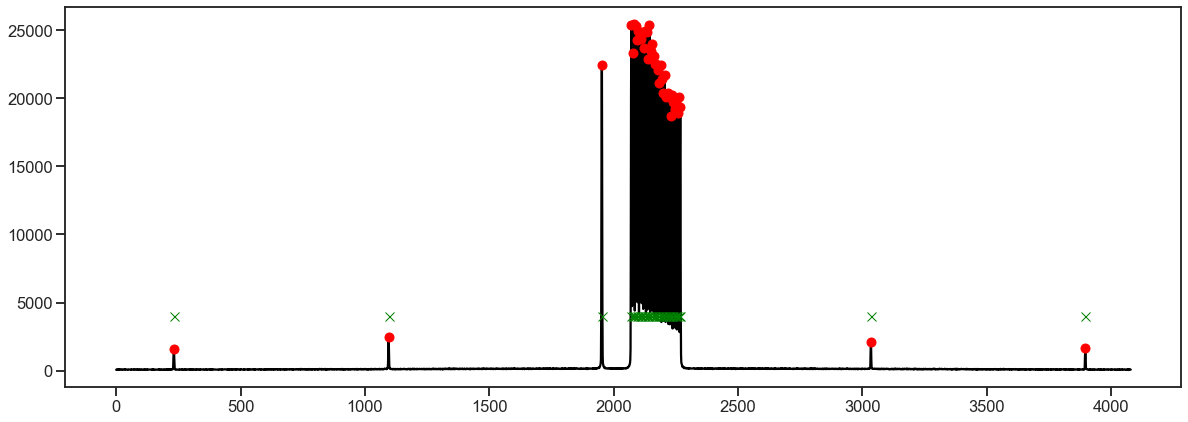

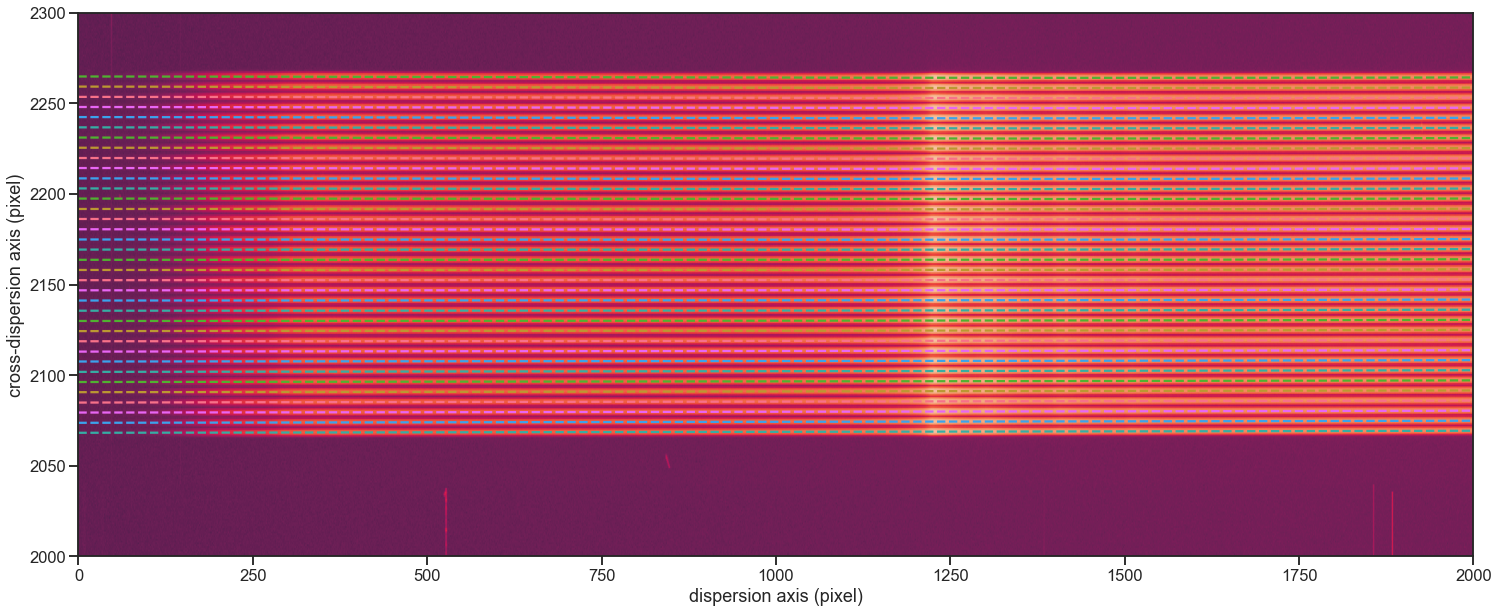

In [13]:
# preprocess frames
# remove overscan regions & compute bias
# remove bias
# join amplifiers
imageMethod.preprocRawFrame_drp(
	cont_path,
	f"_data-lvm/{cont_name}.pre.fits",
	boundary_x="1,2040",
	boundary_y="1,2040",
	positions="00,10,01,11",
	orientation="S,S,S,S"
)
# subprocess.run(f"ds9 _data-lvm/{cont_name}.pre.fits".split())

# remover rayos cosmicos (no es necesario para datos del lab, tiempos de exposicion cortos). El resultado es guardado en *cosmic
# imageMethod.LACosmic_drp(os.path.join(LVM_ROOT,f"{cont_name}.fits"), out_image=f"_data-lvm/{cont_name}.cosmic.fits", increase_radius=1, flim="1.3", parallel='1')
imageMethod.LACosmic_drp(
    f"_data-lvm/{cont_name}.pre.fits",
    out_image=f"_data-lvm/{cont_name}.cosmic.fits",
    increase_radius=1, flim="1.3", parallel='10'
)

# deteccion de picos en el eje de cros-dispersion para un pixel dado. El resultado es guardado en *trace
# imageMethod.findPeaksAuto_drp(f"_data-lvm/{cont_name}.cosmic.fits", out_peaks_file=f"_data-lvm/{cont_name}.trace.peaks", nfibers=382)
imageMethod.findPeaksAuto_drp(
    f"_data-lvm/{cont_name}.cosmic.fits",
    out_peaks_file=f"_data-lvm/{cont_name}.trace.peaks",
    disp_axis="X", threshold="5000", slice="3696", nfibers="41", median_box="1", median_cross="1", method="gauss", init_sigma="0.5", verbose=1
)

# trazado de picos, consiste en localizar las fibras a lo largo del eje de cros-dispersion usando la deteccion de picos en el paso anterior
# es equivalente a propagar la localizacion de los picos para un pixel a lo largo del eje de dispersion. El resultado es guardado en *trc
# imageMethod.tracePeaks_drp(
#     f"_data-lvm/{cont_name}.cosmic.fits",
#     peaks_file=f"_data-lvm/{cont_name}.trace.peaks",
#     trace_out=f"_data-lvm/{cont_name}.trc.fits",
#     steps=30,
#     method="gauss",
#     threshold_peak=50, poly_disp=5, coadd=30, verbose=0
# )
imageMethod.tracePeaks_drp(
    f"_data-lvm/{cont_name}.cosmic.fits",
    peaks_file=f"_data-lvm/{cont_name}.trace.peaks", trace_out=f"_data-lvm/{cont_name}.trc.fits",
    steps=30, method="gauss", threshold_peak=50, poly_disp=5, coadd=30, verbose=1
)
cosmic = fits.open(f"_data-lvm/{cont_name}.cosmic.fits")
trace = fits.open(f"_data-lvm/{cont_name}.trc.fits")

plt.figure(figsize=(25,10))
plt.imshow(np.log10(cosmic[0].data), origin="lower")
plt.gca().set_aspect("auto")
plt.xlim(0,2000)
plt.ylim(2000,2300)
plt.xlabel("dispersion axis (pixel)")
plt.ylabel("cross-dispersion axis (pixel)")

# plt.figure(figsize=(20,))
xx = np.arange(cosmic[0].data.shape[1])
for iy in range(trace[0].data.shape[0]):
    yy = trace[0].data[iy,:]
    plt.plot(xx, yy, "--")

# remover luz directa (stray light). El resultado se guarda en *back (el fondo de luz directa) y *stray (el frame corregido)
# imageMethod.subtractStraylight_drp(
#     f"_data-lvm/{cont_name}.cosmic.fits",
#     f"_data-lvm/{cont_name}.trc.fits",
#     f"_data-lvm/{cont_name}.back.fits",
#     f"_data-lvm/{cont_name}.stray.fits", aperture=40, poly_cross=2, smooth_gauss=30
# )
imageMethod.subtractStraylight_drp(
    f"_data-lvm/{cont_name}.cosmic.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{cont_name}.back.fits",
    f"_data-lvm/{cont_name}.stray.fits",
    aperture=40, poly_cross=2, smooth_gauss=30
)
# subprocess.run(f"ds9 _data-lvm/{cont_name}.cosmic.fits _data-lvm/{cont_name}.stray.fits".split(), capture_output=True)

# traza el ancho de cada espectro a lo largo de cross-dispersion
# El resultado es guardado en *fwhm
# imageMethod.traceFWHM_drp(
#     f"_data-lvm/{cont_name}.stray.fits",
#     f"_data-lvm/{cont_name}.trc.fits",
#     f"_data-lvm/{cont_name}.fwhm.fits",
#     blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,4.0"
# )
imageMethod.traceFWHM_drp(
    f"_data-lvm/{cont_name}.stray.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{cont_name}.fwhm.fits",
    blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,4.0"
)
# subprocess.run(f"ds9 _data-lvm/{cont_name}.fwhm.fits".split())

# extraccion (usando el FWHM), usando como entrada el FWHM resultado de traceFWHM_drp. El resultado es guardado en *ms
# imageMethod.extractSpec_drp(
#     f"_data-lvm/{cont_name}.stray.fits",
#     f"_data-lvm/{cont_name}.trc.fits",
#     f"_data-lvm/{cont_name}.ms.fits",
#     fwhm=f"_data-lvm/{cont_name}.fwhm.fits",
#     method="optimal", parallel=5
# )
imageMethod.extractSpec_drp(
    f"_data-lvm/{cont_name}.stray.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{cont_name}.ms.fits",
    fwhm=f"_data-lvm/{cont_name}.fwhm.fits",
    parallel=5, method="optimal"
)

In [14]:
# extraccion del arco
imageMethod.preprocRawFrame_drp(
	arc_path,
	f"_data-lvm/{arc_name}.pre.fits",
	boundary_x="1,2040",
	boundary_y="1,2040",
	positions="00,10,01,11",
	orientation="S,S,S,S"
)
# subprocess.run(f"ds9 _data-lvm/{arc_name}.pre.fits".split())

# remover rayos cosmicos (no es necesario para datos del lab, tiempos de exposicion cortos). El resultado es guardado en *cosmic
imageMethod.LACosmic_drp(
    f"_data-lvm/{arc_name}.pre.fits",
    out_image=f"_data-lvm/{arc_name}.cosmic.fits",
    increase_radius=1, flim="1.3", parallel='10'
)
imageMethod.subtractStraylight_drp(
    f"_data-lvm/{arc_name}.cosmic.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{arc_name}.back.fits",
    f"_data-lvm/{arc_name}.stray.fits",
    aperture=40, poly_cross=2, smooth_gauss=30
)
imageMethod.extractSpec_drp(
    f"_data-lvm/{arc_name}.stray.fits",
    f"_data-lvm/{cont_name}.trc.fits",
    f"_data-lvm/{arc_name}.ms.fits",
    fwhm=f"_data-lvm/{cont_name}.fwhm.fits",
    method="optimal", parallel="5"
)

subprocess.run(f"ds9 _data-lvm/{arc_name}.ms.fits".split())


CompletedProcess(args=['ds9', '_data-lvm/sdR-s-z1-00001563.ms.fits'], returncode=0)

In [56]:
# 360-593 nm (Blue channel CCDs)
# 566-772 nm (Red channel CCDs)
# 747-980 nm (NIR channel CCDs)
# wli, wlf = 3600, 5930
# wli, wlf = 5660, 7720
wli, wlf = 7470, 9800
ised = 21

neon_ref = pd.read_csv("_data-lvm/neon-lines-desi.txt", sep="\s+", comment="#", names=["Wavelength", "Spectrum", "Spectrograph"]).sort_values("Wavelength").set_index("Wavelength")
neon_cur_ref = neon_ref.Spectrum
neon_cur_ref = neon_cur_ref.str.strip().str.isalpha().astype(int)
neon_cur_ref = neon_cur_ref.loc[(wli<=neon_cur_ref.index)&(neon_cur_ref.index<=wlf)]
neon_cur_ref = neon_cur_ref.loc[neon_cur_ref!=0]

print(len(neon_cur_ref))

del_wl = np.diff(neon_cur_ref.index).min()
new_wl = np.unique(np.arange(wli, wlf+del_wl, del_wl).tolist()+neon_cur_ref.index.to_list())
neon_spec = neon_cur_ref.reindex(new_wl).fillna(0)
# # neon_spec.plot(figsize=(25,5))
# # plt.gca().set_yscale("log")

ext, ext_header = fits.getdata(f"_data-lvm/{arc_name}.ms.fits", header=True)
target_spec = ext[ised]
# target_spec[target_spec<target_spec.std()] = 0

32


In [57]:
neon_ref

,Spectrum,Spectrograph
Wavelength,,
3611.5375,CdI,B
3651.1980,HgI,B
3655.8830,HgI,B
3664.3270,HgI,B
4047.7080,HgI,B
...,...,...
9660.4350,ArI,Z
9668.0709,NeI,Z
9787.1860,ArI,Z


In [58]:
pd.DataFrame(neon_cur_ref).rename(columns={"Spectrum":"Intensity"}).reset_index()

,Wavelength,Intensity
0,7490.9335,1
1,7537.8488,1
2,7603.6384,1
3,7637.2080,1
4,7696.6579,1
5,7725.8870,1
6,7945.3654,1
7,8061.7211,1
8,8105.9210,1
9,8117.5420,1


In [74]:
from copy import deepcopy as copy


neon_nist = pd.read_csv("_data-lvm/neon-lines-nist.txt", sep="\s+", comment="#").set_index("Wavelength")
neon_nist = neon_nist.loc[(wli<=neon_nist.index)&(neon_nist.index<=wlf)]
neon_nist_or = copy(neon_nist)
neon_nist = neon_nist.reindex(new_wl).fillna(0)
neon_nist

,Intensity,Spectrum
Wavelength,,
7470.0000,0.0,0
7477.0053,0.0,0
7484.0106,0.0,0
7490.9335,0.0,0
7491.0159,0.0,0
...,...,...
9781.7490,0.0,0
9787.1860,0.0,0
9788.7543,0.0,0


In [75]:
neon_nist_or

,Intensity,Spectrum
Wavelength,,
7472.4386,30,NeI
7488.8712,300,NeI
7492.1020,100,NeII
7522.8180,150,NeII
7535.7741,300,NeI
...,...,...
9486.6818,50,NeI
9534.1629,60,NeI
9547.4049,30,NeI


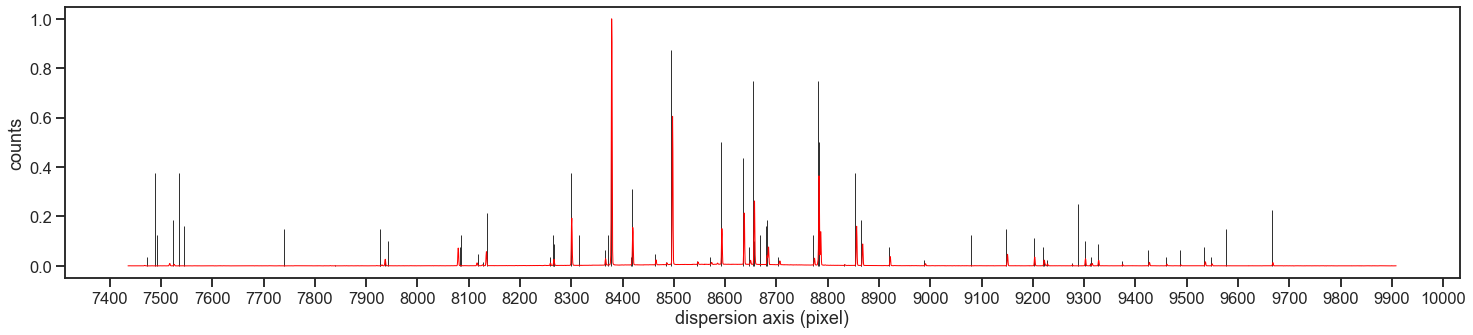

In [101]:
import matplotlib.ticker as plticker


# initial guess: a linear interpolation in the known range
guess_wl = np.linspace(wli, wlf, ext[ised].size)

plt.figure(figsize=(25,5))
# plt.vlines(neon_cur_ref.index, ymin=0, ymax=1, colors="0.2", lw=1)
plt.vlines(neon_nist_or.index, ymin=0, ymax=neon_nist_or.Intensity/neon_nist_or.Intensity.max(), colors="0.2", lw=1)
plt.plot(-0.000049*(guess_wl+110-8860)**2+1.05*(guess_wl+110-8860)+8860, ext[ised][::]/ext[ised].max(), color="r", lw=1)
plt.xlabel("dispersion axis (pixel)")
plt.ylabel("counts")
# this locator puts ticks at regular intervals
loc = plticker.MultipleLocator(base=100)
plt.gca().xaxis.set_major_locator(loc)
#plt.yscale("sqrt")

# neon_spec.mask(neon_spec==0).dropna()

In [34]:
# plt.figure(figsize=(25,5))
# plt.plot(neon_spec.index, neon_spec.values)
# plt.xlabel("Wavelength")
# plt.ylabel("Intensity")

In [35]:
# from scipy.spatial.distance import euclidean
# from fastdtw import fastdtw


# dist, path = fastdtw(np.log10(1+neon_spec/neon_spec.max()), np.log10(1+target_spec/target_spec.max()), dist=euclidean, radius=100)
# print("distance:", dist)

In [36]:
# ineon, itarget = zip(*path)

# plt.figure(figsize=(25,5))
# plt.plot(np.log10(1+neon_spec.values[list(ineon)]/neon_spec.max()), lw=2)
# plt.plot(np.log10(1+target_spec[list(itarget)]/target_spec.max()), lw=1)

# mask = (neon_spec.values[list(ineon)]!=0)&(target_spec[list(itarget)]>1*np.std(target_spec[list(itarget)]))
# pix_map_table = np.column_stack((np.arange(target_spec.size)[list(itarget)], neon_spec.index.values[list(ineon)], np.ones(len(ineon))))[mask]
# _, idx = np.unique(pix_map_table[:,1], return_index=True)
# with open("_data-lvm/dtw-neon.txt", "w") as f:
#     f.write(f"{ised}\n")
#     np.savetxt(f, pix_map_table[idx], fmt="%.2f %.2f %d")

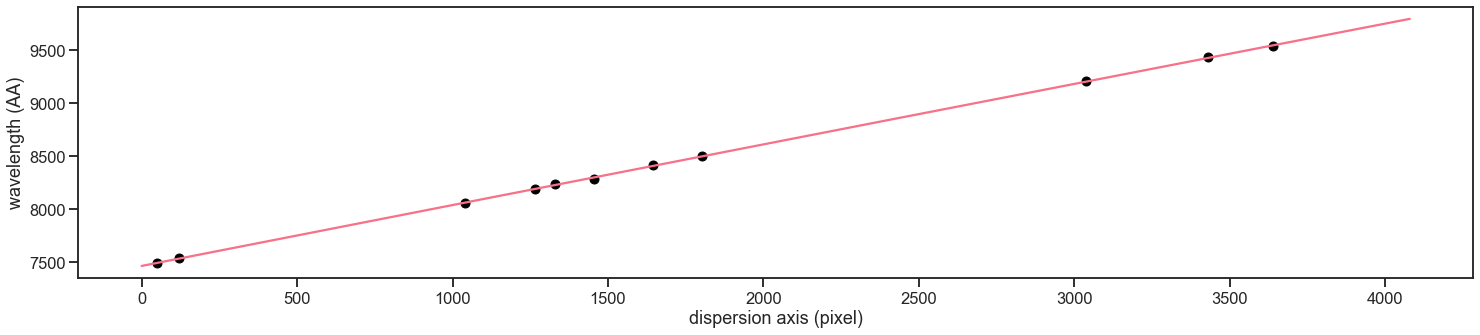

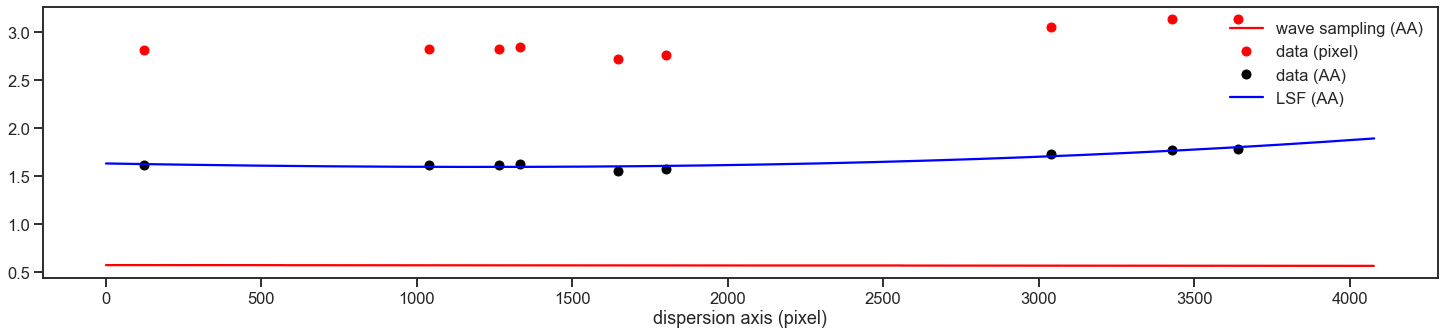

In [37]:
# np.seterr(all="raise")

# solucion de longitud de onda
# este paso deberia hacerse en simultaneo con el trazado de la FWHM (espacial), solucion simultanea en espacio y wavelength es el spectroperfectionism
# *.res.fits es la LSF
# *.disp.fits es el muestreo en wavelength
wave, fwhm = rssMethod.detWaveSolution_drp(
    f"_data-lvm/{arc_name}.ms.fits",
    f"_data-lvm/{arc_name}.disp.fits",
    f"_data-lvm/{arc_name}.res.fits",
    # f"_data-lvm/neon-lines_cor.txt",
    f"_data-lvm/lvm-neon_cor.txt",
    aperture="12", poly_fwhm="-7,-3", poly_dispersion="-2", rel_flux_limits="0.2,2", flux_min="100.0", verbose="0"
)
# subprocess.run(f"ds9 {arc_name}.disp.fits {arc_name}.res.fits".split())

# a#adir solucion a los RSS, usando la determinacion de la solucion de longitud de onda en *disp y *res. El resultado es guardado en *rss
# esto no remuestrea los espectros al mismo vector de longitudes de onda
rssMethod.createPixTable_drp(
    f"_data-lvm/{arc_name}.ms.fits",
    f"_data-lvm/{arc_name}.rss.fits",
    f"_data-lvm/{arc_name}.disp.fits", arc_fwhm=f"_data-lvm/{arc_name}.res.fits", cropping=''
)

# remuestrea los espectros a un vector de longitudes de onda comun. Crea *.disp_cor
rssMethod.resampleWave_drp(
    f"_data-lvm/{arc_name}.rss.fits", f"_data-lvm/{arc_name}.disp_cor.fits",
    start_wave=wli, end_wave=wlf, disp_pix="1.0", err_sim="0"
)

# subprocess.run(f"ds9 _data-lvm/{arc_name}.rss.fits _data-lvm/{arc_name}.disp_cor.fits".split())

In [38]:
f = fits.open(f"_data-lvm/{arc_name}.disp.fits")
f[0].data[ised,[0,-1]], wli, wlf

(array([7465.0273, 9791.588 ], dtype=float32), 7470, 9800)

Text(0, 0.5, 'counts')

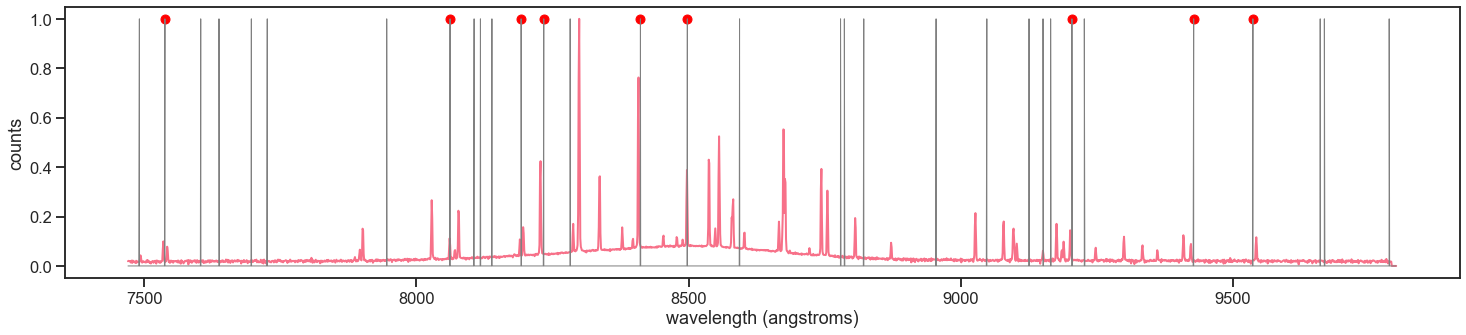

In [39]:
rss = rssMethod.loadRSS(f"_data-lvm/{arc_name}.disp_cor.fits")

ref_table = np.loadtxt("_data-lvm/lvm-neon_cor.txt", skiprows=1)
ref_table = ref_table[ref_table[:,2].astype(bool)]

plt.figure(figsize=(25,5))
plt.plot(rss._wave, np.sqrt(rss._data[ised]/rss._data[ised].max()), lw=2)
plt.plot(ref_table[:,1], np.ones_like(ref_table[:,1]), "or")
(neon_spec/neon_spec.max()).plot(ax=plt.gca(), lw=1, color="0.5")
plt.xlabel("wavelength (angstroms)")
plt.ylabel("counts")

In [24]:
f = fits.open(f"_data-lvm/{arc_name}.rss.fits")
f.info()

Filename: _data-lvm/sdR-s-z1-00001563.rss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (4079, 41)   float32   
  1  WAVE          1 ImageHDU         8   (4079, 41)   float32   
  2  INSTFWHM      1 ImageHDU         8   (4079, 41)   float32   
  3  ERROR         1 ImageHDU         8   (4079, 41)   float32   
  4  BADPIX        1 ImageHDU         8   (4079, 41)   uint8   


Text(0, 0.5, 'LSF (AA)')

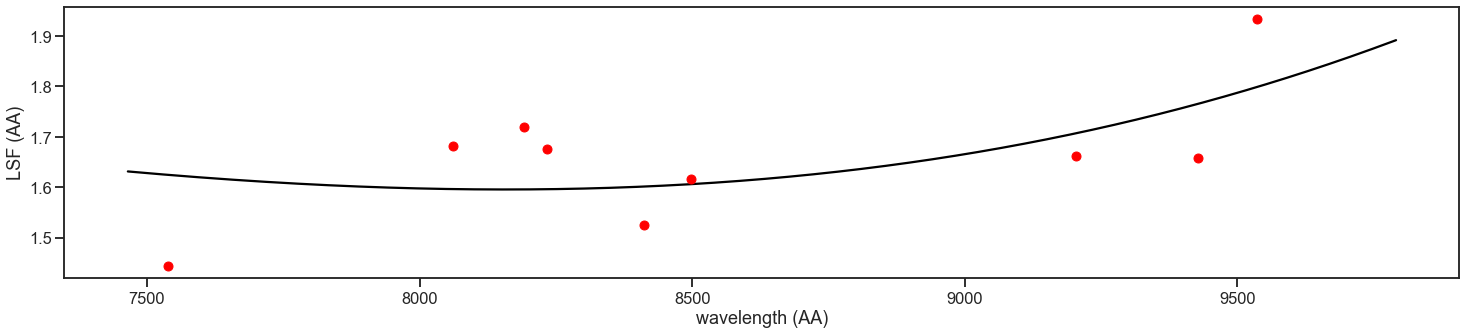

In [25]:
plt.figure(figsize=(25,5))
plt.plot(f[1].data[ised], f[2].data[ised], "k")
plt.plot(ref_table[:,1], fwhm, "or")
plt.xlabel("wavelength (AA)")
plt.ylabel("LSF (AA)")

Text(0, 0.5, 'resolving power')

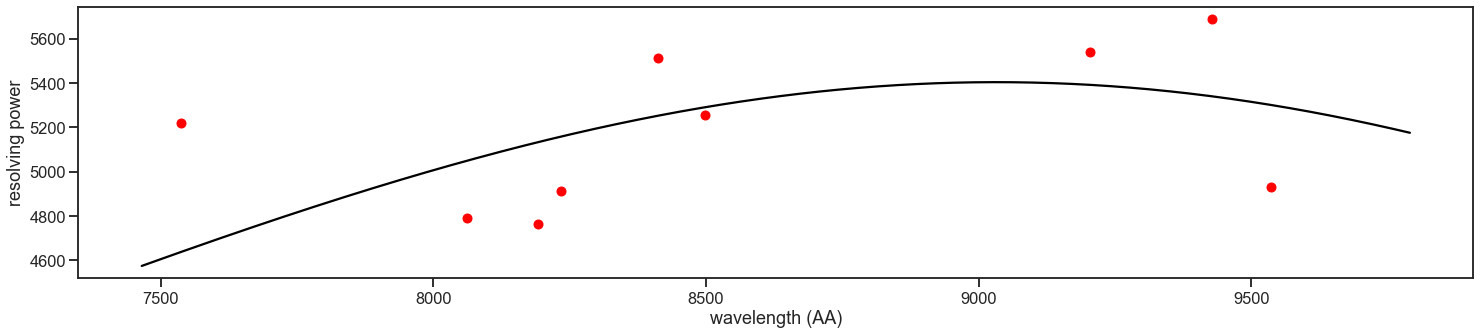

In [26]:
plt.figure(figsize=(25,5))
plt.plot(f[1].data[ised], f[1].data[ised]/f[2].data[ised], "k")
plt.plot(ref_table[:,1], ref_table[:,1]/fwhm, "or")
plt.xlabel("wavelength (AA)")
plt.ylabel("resolving power")
# TODO: add measured widths in this plot